In [38]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler import generate_preset_pass_manager
import qiskit_ibm_runtime.fake_provider as fk  
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import ClassicalRegister
from qiskit.transpiler import Layout, CouplingMap
from qiskit.visualization import plot_circuit_layout, plot_histogram
from qiskit_aer import AerSimulator
from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import warnings
#supress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Generalization Notebook

- This notebook is designed to generalize the Adaptive Cyclic Layout Map algorithm, i.e ACLM to multi-qubit gates and disordered structures
- The ACLM optimizes the layout transpiler pass (hardware aware mapping of logical qubits to physical qubits)
- See the jupyter notebook: `adaptive cyclic layout map.ipynb` for an introduction to the algorithm, as well as relevant use cases.

## Objectives

- We compare 'sabre', 'ACLM', and 'reordered-ACLM' with different set of CNOT gates
- We use a ordering function to find the best sequence of qubits in the cycle for each circuit implementation
- We focus on measuring **circuit depth**, and **CNOT gates** (native entangling gates) for different implementations of the layout transpiler passes
- We show that the 'reordered-ACLM' passes outperform the given native passes by reducing the circuit depth and CNOT

----

The notebook is organized as follows:

* [Initialize ACLM functions](#initialize-aclm-functions)
* [Initialize Ordering Function](#initialize-ordering-function)
* [Generalizing to Disordered Multi-Qubit Gates](#generalizing-to-disordered-multi-qubit-gates)
    - [Case 1](#case-1)
    - [Case 2](#case-2)
    - [Case 3](#case-3)
---

### Initialize ACLM functions ###

The functions defined below find the best simple cycle for  a given circuit.
See the jupyter notebook: `adaptive cyclic layout map.ipynb`  for an introduction to the algorithm, as well as relevant use cases.

For a given hardware, Logical qubits are mapped to physical qubits in a cyclic order.
- Uses the Networkx python package to represent the coupling map (for a given backend hardware) as a graph, and then finds the set of simple cycles in the graph
- For a given circuit with n-qubits, we try to obtain a cycle with length n

In [ ]:

def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Finds an exact cycle of length n, else return the nearest larger cycle.
    Inputs:
        coupling_map: CouplingMap object representing the hardware connectivity
        n: Desired cycle length
    Returns:
        A cycle of length n if found, otherwise the smallest larger cycle, or None if no cycles exist.
    """
    #Convert CouplingMap to NetworkX graph
    G = nx.Graph()

    #Add edges from the coupling map to the NetwrkX graph object
    G.add_edges_from(coupling_map.get_edges())

    #Find all simple cycles in the graph
    cycles = list(nx.simple_cycles(G))

    #cycles with desired length n
    exact = [c for c in cycles if len(c) == n]
    #cycles with length larger than n
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):

    """
    Adaptive layout for ring circuits: suggests ancilla qubits if needed
    Inputs: 
        logical_qubits: Number of logical qubits in the circuit
        coupling_map: CouplingMap object representing the hardware connectivity

    Returns:
        required_qubits: Total number of qubits needed (logical + ancilla)
        ancilla: Number of ancilla qubits required (if any)

    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits


    return required_qubits, ancilla


___

### Initialize Ordering function ###

The function defined below find the order of qubits in a cycle to find the best sequence. As the disorder in the circuit increases, CNOT gates do not occur between adjacent qubits and creating qubit cycles as '0-1-2-3-4-5-...-n-0', which requires reordering of qubits in mapping.

Ordering function calculates distance between each possible multi-qubit gates and tries to change place of qubits to minimize sum of all distances.
- Uses cp_model from OR TOOL package to solve min-cost problem
- For a given circuit with multi-qubit gates, the function return the new order of qubits

In [40]:
def solve_min_cost(n, sets):
    """
    Find the sequence minimizing the distance between qubits in multi-qubit gates
    Input:
        n: Number of qubits
        sets: Set of qubits of mult-qubit gates
    Output:
        result: Ordered set of qubits
    """
    model = cp_model.CpModel()

    # Add every possible integer to the model
    x = [model.NewIntVar(0, n - 1, f'x{i}') for i in range(n)]
    model.AddAllDifferent(x)

    cost_terms = []

    # For each set calculate the distance, namely cost
    for s in sets:
        vals_in_set = [x[i] for i in s]

        min_val = model.NewIntVar(0, n - 1, f'min_{"_".join(map(str, s))}')
        max_val = model.NewIntVar(0, n - 1, f'max_{"_".join(map(str, s))}')
        diff = model.NewIntVar(0, n - 1, f'diff_{"_".join(map(str, s))}')

        model.AddMinEquality(min_val, vals_in_set)
        model.AddMaxEquality(max_val, vals_in_set)
        model.Add(diff == max_val - min_val)

        cost_terms.append(diff)

    # Minimize the cost
    total_cost = model.NewIntVar(0, n * (n - 1), 'total_cost')
    model.Add(total_cost == sum(cost_terms))
    model.Minimize(total_cost)

    # Find the optimal solution
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # If there is not error in solver, give the results
    # Order should be argsorted because the result tell us where should be the ordered qubits.
    # For example, first qubit in the physical layout should be the qubit corresponding to the index of 0 on the result
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        result = [solver.Value(xi) for xi in x]
        return np.argsort(result), solver.Value(total_cost)
    else:
        return None, None

___

### Generalizing to Disordered Multi-Qubit Gates ###

#### Case 1 ####
- Create sequential CNOT gates but with a random order for 28 qubits
- Compare transpilation results for 'sabre', 'ACLM', and 'reordered-ACLM'

Depth (Sabre | Circle | Reordered Circle):  78  |  171  |  27
CNOT count (Sabre | Circle | Reordered Circle):  65  |  307  |  27


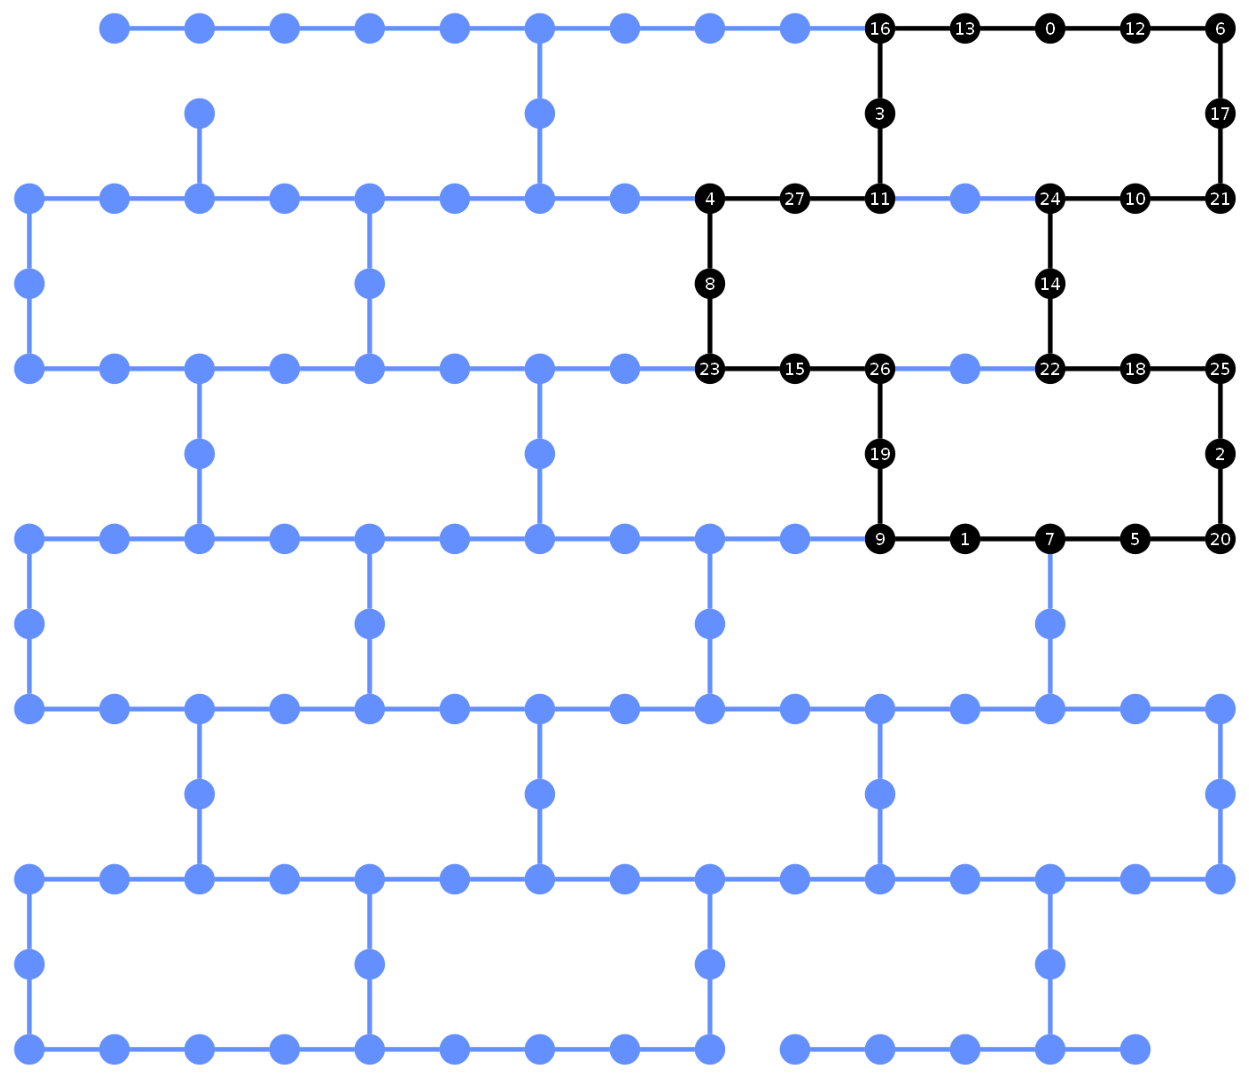

In [42]:
# Create a 28 qubits circuit with sequential but not ordered CX gates
SEED = 40
nums, n = np.arange(28), 28
dublets = []

# Delete each qubit from the list after a CX gate is connected and assign it for the next CX gate
k = nums[np.random.randint(0,len(nums))]
nums = np.delete(nums,np.where(nums==k))
for i in range(27):
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    dublets.append((k,l))
    k = l

# Constitute the quantum circuit and apply CX gates
qc = QuantumCircuit(28)
for i, j in dublets:
    qc.cx(qc.qubits[i],qc.qubits[j])

# Create the backend and obtaing coupling map
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Calculate the best order
order, cost = solve_min_cost(28, dublets)

# Map the qubits for ACLM
layout_dict = {qc.qubits[i]: cycle[i] for i in range(28)}
layout_aclm = Layout(layout_dict)

# Map the qubits for reordered-ACLM
layout_dict = {qc.qubits[order[i]]: cycle[i] for i in range(28)}
layout_reordered_aclm = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for ACLM layout
pass_manager_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_aclm,
        seed_transpiler=SEED)

# Pass manager for reordered-ACLM layout
pass_manager_reordered_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_reordered_aclm,
        seed_transpiler=SEED)

# Transpile circuits using pass managers
sabre_transpiled_circuit = pass_manager_sabre.run(qc)
aclm_transpiled_circuit = pass_manager_aclm.run(qc)
reordered_aclm_transpiled_circuit = pass_manager_reordered_aclm.run(qc)

# Comparison results
print("Depth (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.depth(), " | ", aclm_transpiled_circuit.depth(), " | ", reordered_aclm_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", aclm_transpiled_circuit.count_ops().get("cx", 0), " | ", reordered_aclm_transpiled_circuit.count_ops().get("cx",0))

# Plot the layout mapping of reordered ACLM
plot_circuit_layout(reordered_aclm_transpiled_circuit, backend)

| | Sabre | ACLM | Reordered-ACLM |
| --- | --- | --- | --- |
| Depth | 78 | 171 | 27 |
| CNOT Count | 65 | 307 | 27 |

- Results show that 'ACLM' without correct ordering makes it infeasible compared to 'sabre', yet 'reordered-ACLM' dominates in both metrics
- Using ordering function, it is possible to generalize ACLM further
___

#### Case 2 ####
- Create sequential and non-sequential CNOT gates with a random order for 28 qubits
- Compare transpilation results for 'sabre', 'ACLM', and 'reordered-ACLM'

Depth (Sabre | Circle | Reordered Circle):  9  |  65  |  6
CNOT count (Sabre | Circle | Reordered Circle):  31  |  194  |  25


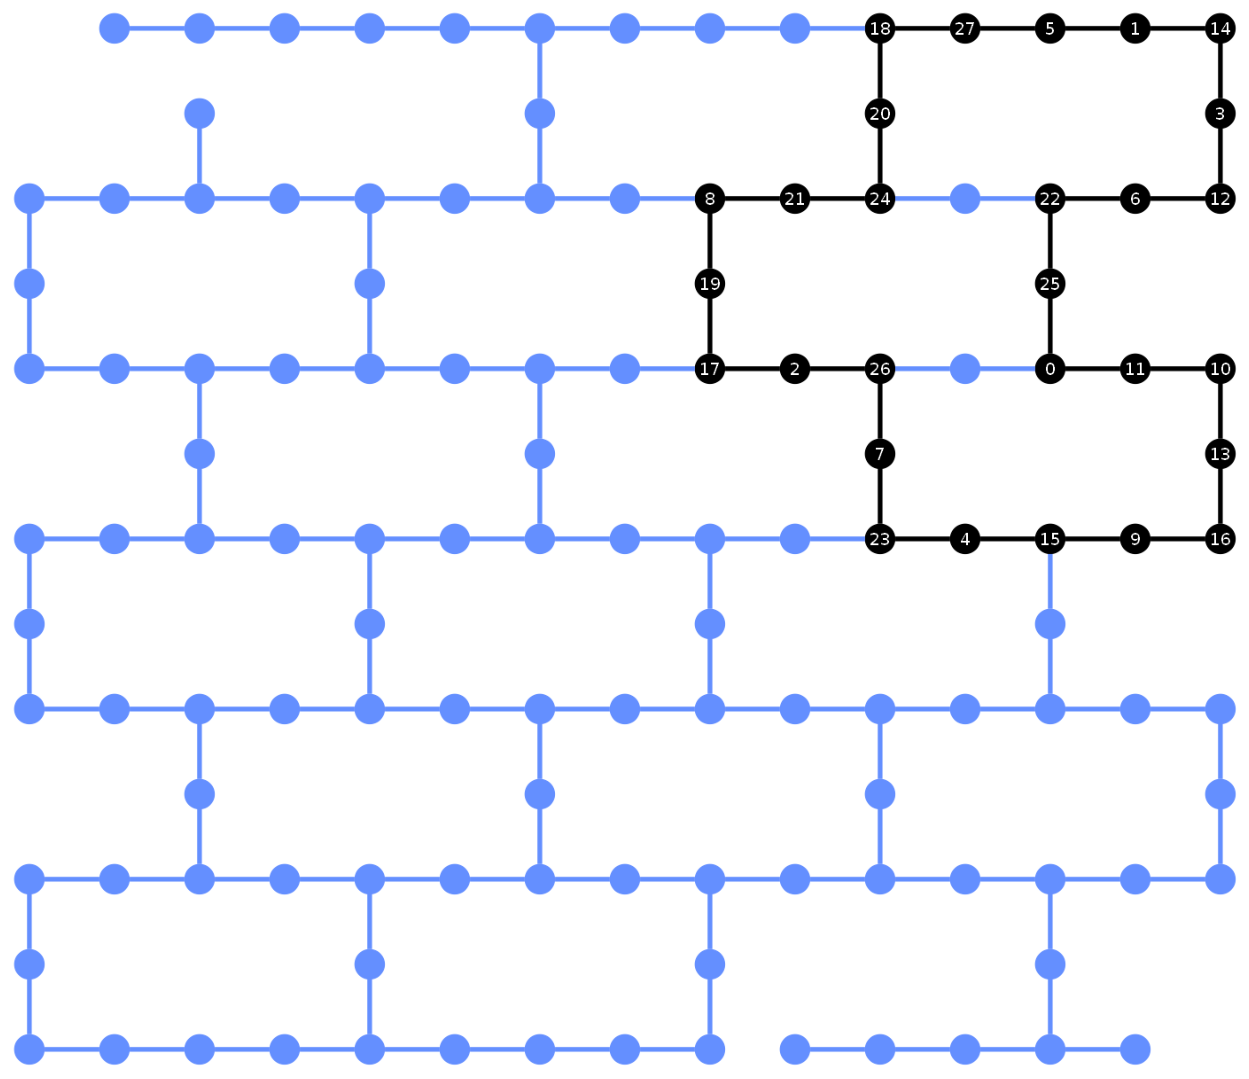

In [43]:
# Create a 28 qubits circuit with sequential but not ordered CX gates
SEED = 40
nums, n = np.arange(28), 28
dublets = []

# Apply CX gate to random qubit couples
for i in range(14):
    k = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==k))
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    dublets.append((k,l))

# Apply additional CX gates to increase disorder
for i in range(5):
    k = np.random.randint(0,28)
    l = np.random.randint(0,28)
    if k != l:
        dublets.append((k,l))

# Create the quantum circuit
qc = QuantumCircuit(28)
for i, j in dublets:
    qc.cx(qc.qubits[i],qc.qubits[j])

# Create the backend and obtaing coupling map
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Calculate the best order
order, cost = solve_min_cost(28, dublets)

# Map the qubits for ACLM
layout_dict = {qc.qubits[i]: cycle[i] for i in range(28)}
layout_aclm = Layout(layout_dict)

# Map the qubits for reordered-ACLM
layout_dict = {qc.qubits[order[i]]: cycle[i] for i in range(28)}
layout_reordered_aclm = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for ACLM layout
pass_manager_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_aclm,
        seed_transpiler=SEED)

# Pass manager for reordered-ACLM layout
pass_manager_reordered_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_reordered_aclm,
        seed_transpiler=SEED)

# Transpile circuits using pass managers
sabre_transpiled_circuit = pass_manager_sabre.run(qc)
aclm_transpiled_circuit = pass_manager_aclm.run(qc)
reordered_aclm_transpiled_circuit = pass_manager_reordered_aclm.run(qc)

# Comparison results
print("Depth (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.depth(), " | ", aclm_transpiled_circuit.depth(), " | ", reordered_aclm_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", aclm_transpiled_circuit.count_ops().get("cx", 0), " | ", reordered_aclm_transpiled_circuit.count_ops().get("cx",0))

# Plot the layout mapping of reordered ACLM
plot_circuit_layout(reordered_aclm_transpiled_circuit, backend)

| | Sabre | ACLM | Reordered-ACLM |
| --- | --- | --- | --- |
| Depth | 9 | 65 | 6 |
| CNOT Count | 31 | 194 | 25 |

- Results show that 'reordered-ACLM' still dominates 'sabre' even though the gap is smaller
- It can be guessed that as disorder increases, the difference between 'reordered-ACLM' and 'sabre decreases
___

#### Case 3 ####

- As a last example, we try to realize random Toffoli gates and try to reach optimum ordering and conditions. This mapping can be very efficient to imply Grover's Diffusion Operator by simplyifing MCX gate using methods like [Khattar and Gidney, 2025](https://arxiv.org/pdf/2407.17966) which have loop patterns with ancilla qubits

Depth (Sabre | Circle | Reordered Circle):  19  |  91  |  22
CNOT count (Sabre | Circle | Reordered Circle):  71  |  261  |  96


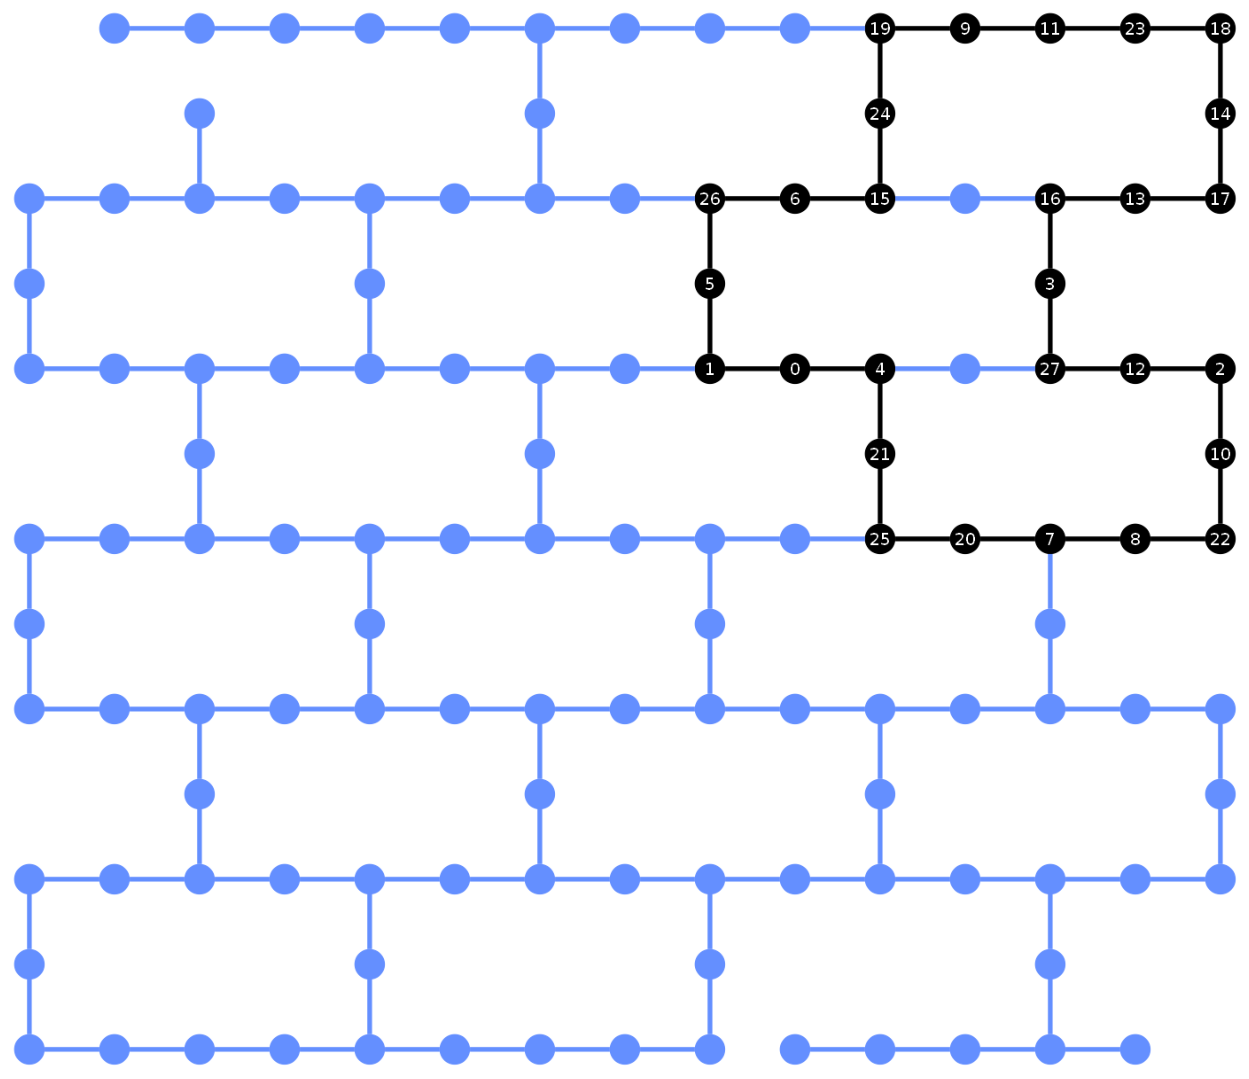

In [50]:
# Create a 28 qubits circuit with sequential but not ordered CX gates
SEED = 40
nums, n = np.arange(28), 28
triplets = []

# Create random triplets for CCX gate
for i in range(9):
    k = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==k))
    l = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==l))
    m = nums[np.random.randint(0,len(nums))]
    nums = np.delete(nums,np.where(nums==m))
    triplets.append((k,l,m))

# Create the Quantum Circuit
qc = QuantumCircuit(28)
for i, j, x in triplets:
    qc.ccx(qc.qubits[i],qc.qubits[j], qc.qubits[x])

# Create the backend and obtaing coupling map
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Obtain cycle-graph
cycle = find_best_cycle(cm, n)

# Calculate the best order
order, cost = solve_min_cost(28, triplets)

# Map the qubits for ACLM
layout_dict = {qc.qubits[i]: cycle[i] for i in range(28)}
layout_aclm = Layout(layout_dict)

# Map the qubits for reordered-ACLM
layout_dict = {qc.qubits[order[i]]: cycle[i] for i in range(28)}
layout_reordered_aclm = Layout(layout_dict)

# Pass manager for Sabre layout
pass_manager_sabre = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method="sabre",
        seed_transpiler=SEED)

# Pass manager for ACLM layout
pass_manager_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_aclm,
        seed_transpiler=SEED)

# Pass manager for reordered-ACLM layout
pass_manager_reordered_aclm = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_reordered_aclm,
        seed_transpiler=SEED)

# Transpile circuits using pass managers
sabre_transpiled_circuit = pass_manager_sabre.run(qc)
aclm_transpiled_circuit = pass_manager_aclm.run(qc)
reordered_aclm_transpiled_circuit = pass_manager_reordered_aclm.run(qc)

# Comparison results
print("Depth (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.depth(), " | ", aclm_transpiled_circuit.depth(), " | ", reordered_aclm_transpiled_circuit.depth())
print("CNOT count (Sabre | Circle | Reordered Circle): ", sabre_transpiled_circuit.count_ops().get("cx", 0), " | ", aclm_transpiled_circuit.count_ops().get("cx", 0), " | ", reordered_aclm_transpiled_circuit.count_ops().get("cx",0))

# Plot the layout mapping of reordered ACLM
plot_circuit_layout(reordered_aclm_transpiled_circuit, backend)

| | Sabre | ACLM | Reordered-ACLM |
| --- | --- | --- | --- |
| Depth | 19 | 91 | 22 |
| CNOT Count | 17 | 261 | 96 |

- 'sabre' and 'reordered-ACLM' are very similar in terms of depth, yet 'sabre' dominates for CNOT count
- For more complex circuits, 'ACLM' or 'reordered-ACLM' can be less efficient in terms of depth and CNOT count
- It is noteworthy to also examine error mitigation in different mappings and our notebook on choosing the minimum error as well as circular mapping can be more efficient.
See `find_best_cycle_with_error_minimization.ipynb` for more detail on error minimization